# Prejudice removal

**Uses the Prejudice removal in-processing algorithm from the AIF360 toolkit. Adds a discrimination-aware regularization term to the learning objective** 

See https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.inprocessing.PrejudiceRemover.html <br />
See http://aif360.mybluemix.net/resources#guidance for guidance on metrics and mitigation algorithms

In [2]:
%matplotlib inline
import os
import sys
sys.path.insert(0, os.path.abspath('../datasets'))
import numpy as np
from tqdm import tqdm
from warnings import warn
import pandas as pd

from IPython.display import Markdown, display
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from common_utils import compute_metrics
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt

from aif360.algorithms.inprocessing import PrejudiceRemover

# Import employment dataset 
from EmploymentDataset import EmploymentDataset
from util import preprocess_employment

/home/khuf/Projects/INFO381/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/khuf/Projects/INFO381/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/khuf/Projects/INFO381/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/khuf/Projects/INFO381/.venv/lib/python3.6/s

Matplotlib Error, comment out matplotlib.use('TkAgg')


/home/khuf/Projects/INFO381/.venv/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/khuf/Projects/INFO381/.venv/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/khuf/Projects/INFO381/.venv/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/khuf/Projects/INFO381/

In [3]:
privileged_groups = [{'Sex': 1}]
unprivileged_groups = [{'Sex': 0}]

# Fairness penalty paramenters
eta = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0] 

#eta = [0.0, 1.0, 2.0]

prejudice_remover = PrejudiceRemover(eta=300, sensitive_attr = 'Sex', class_attr='EmploymentStatus')
prejudice_no_penalty = PrejudiceRemover(eta= 0.0, sensitive_attr = 'Sex', class_attr='EmploymentStatus')
 
# Import the dataset
dataset_orig = preprocess_employment(['Sex'])

# Split dataset 70/30
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

[1. 0.]


In [4]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.098079
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.089304


In [5]:
min_max_scaler = MaxAbsScaler()
dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())

#### Scaled dataset - Verify that the scaling does not affect the group label statistics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.098079
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.089304


In [6]:
# Train the model
prejudice_no_penalty.fit(dataset_orig_train)

In [7]:
# Apply the unconstrained model to test data
dataset_train_transformed_plain = prejudice_no_penalty.predict(dataset_orig_train)
dataset_test_transformed_plain = prejudice_no_penalty.predict(dataset_orig_test)

In [8]:
# Metrics for the dataset from model without debiasing
display(Markdown("## No fairness contraints - dataset metrics"))
display(Markdown("#### Model without debiasing - dataset metrics"))
metric_dataset_prejudiceremover_train = BinaryLabelDatasetMetric(dataset_train_transformed_plain, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_prejudiceremover_train.mean_difference())

metric_dataset_prejudiceremover_test = BinaryLabelDatasetMetric(dataset_test_transformed_plain, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_prejudiceremover_test.mean_difference())

display(Markdown("#### Model without debiasing - classification metrics"))
classified_metric_prejudiceremover_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_test_transformed_plain,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_prejudiceremover_test.accuracy())
TPR = classified_metric_prejudiceremover_test.true_positive_rate()
TNR = classified_metric_prejudiceremover_test.true_negative_rate()
bal_acc_predjudiceremover_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_predjudiceremover_test)
print("Test set: Disparate impact = %f" % classified_metric_prejudiceremover_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_prejudiceremover_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_prejudiceremover_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_prejudiceremover_test.theil_index())

## No fairness contraints - dataset metrics

#### Model without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.025933
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.020669


#### Model without debiasing - classification metrics

Test set: Classification accuracy = 0.815069
Test set: Balanced classification accuracy = 0.662604
Test set: Disparate impact = 0.976715
Test set: Equal opportunity difference = -0.024389
Test set: Average odds difference = 0.046790
Test set: Theil_index = 0.077106


In [9]:
prejudice_remover.fit(dataset_orig_train)

In [10]:
# Apply the prejudice remover model to test data
dataset_train_transformed = prejudice_remover.predict(dataset_orig_train)
dataset_test_transformed = prejudice_remover.predict(dataset_orig_test)

In [11]:
display(Markdown("## No fairness contraints - dataset metrics"))
# Metrics for the dataset from model without debiasing
display(Markdown("#### Model without debiasing - dataset metrics"))
metric_dataset_prejudiceremover_train = BinaryLabelDatasetMetric(dataset_train_transformed_plain, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_prejudiceremover_train.mean_difference())

metric_dataset_prejudiceremover_test = BinaryLabelDatasetMetric(dataset_test_transformed_plain, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_prejudiceremover_test.mean_difference())

display(Markdown("#### Model without debiasing - classification metrics (test set)"))
classified_metric_prejudiceremover_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_test_transformed_plain,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_prejudiceremover_test.accuracy())
TPR = classified_metric_prejudiceremover_test.true_positive_rate()
TNR = classified_metric_prejudiceremover_test.true_negative_rate()
bal_acc_predjudiceremover_test = 0.5*(TPR+TNR)
unconstrainedFDR = classified_metric_prejudiceremover_test.false_discovery_rate()
print("Test set: Balanced classification accuracy = %f" % bal_acc_predjudiceremover_test)
print("Test set: Disparate impact = %f" % classified_metric_prejudiceremover_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_prejudiceremover_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_prejudiceremover_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_prejudiceremover_test.theil_index())

###### Debiasing begins here ############


display(Markdown("## With fairness constraints - dataset metrics"))

# Metrics for the dataset from model with debiasing
display(Markdown("#### Model with debiasing - dataset metrics"))
metric_dataset_prejudiceremover_train = BinaryLabelDatasetMetric(dataset_train_transformed, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_prejudiceremover_train.mean_difference())

metric_dataset_prejudiceremover_test = BinaryLabelDatasetMetric(dataset_test_transformed, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_prejudiceremover_test.mean_difference())

display(Markdown("#### Model with biasing - classification metrics (test set)"))
classified_metric_prejudiceremover_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_test_transformed,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_prejudiceremover_test.accuracy())
TPR = classified_metric_prejudiceremover_test.true_positive_rate()
TNR = classified_metric_prejudiceremover_test.true_negative_rate()
bal_acc_predjudiceremover_test = 0.5*(TPR+TNR)
print("Balanced classification accuracy = %f" % bal_acc_predjudiceremover_test)
print("Test set: Disparate impact = %f" % classified_metric_prejudiceremover_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_prejudiceremover_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_prejudiceremover_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_prejudiceremover_test.theil_index())


## No fairness contraints - dataset metrics

#### Model without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.025933
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.020669


#### Model without debiasing - classification metrics (test set)

Test set: Classification accuracy = 0.815069
Test set: Balanced classification accuracy = 0.662604
Test set: Disparate impact = 0.976715
Test set: Equal opportunity difference = -0.024389
Test set: Average odds difference = 0.046790
Test set: Theil_index = 0.077106


## With fairness constraints - dataset metrics

#### Model with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = 0.000000
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.000000


#### Model with biasing - classification metrics (test set)

Test set: Classification accuracy = 0.760912
Balanced classification accuracy = 0.500000
Test set: Disparate impact = 1.000000
Test set: Equal opportunity difference = 0.000000
Test set: Average odds difference = 0.000000
Test set: Theil_index = 0.053117


In [12]:
display(Markdown("#### Running the algorithm for different eta values"))

accuracies, false_discovery_rates, statistical_rates = [], [], []
sensitive_attribute = "Sex"

all_eta = np.linspace(0.0, 300, 17)
for e in eta:
    print("eta: %.2f" % e)
    debiased_model = PrejudiceRemover(eta=e, sensitive_attr=sensitive_attribute)
    debiased_model.fit(dataset_orig_train)
    
    dataset_debiasing_test = debiased_model.predict(dataset_orig_test)
    predictions = dataset_debiasing_test.labels
    predictions = [1 if y == dataset_orig_train.favorable_label else -1 for y in predictions]
    
    classified_metric_prejudiceremover_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    acc = 0.5*(classified_metric_prejudiceremover_test.true_positive_rate()+classified_metric_prejudiceremover_test.true_negative_rate())
    sp =  classified_metric_prejudiceremover_test.mean_difference()
    fr = classified_metric_prejudiceremover_test.false_discovery_rate()
    print("accuracy: %.2f" % acc)
    print("fdr: %.2f" % fr)
    print("statistical parity: %.2f" % sp)
    
    ## Testing
    assert (e < unconstrainedFDR) or (fr >= unconstrainedFDR)
    
    accuracies.append(acc)
    false_discovery_rates.append(fr)
    statistical_rates.append(sp)
    

#### Running the algorithm for different eta values

eta: 0.00
accuracy: 0.66
fdr: 0.17
statistical parity: -0.02
eta: 1.00
accuracy: 0.66
fdr: 0.17
statistical parity: -0.02
eta: 2.00
accuracy: 0.66
fdr: 0.17
statistical parity: -0.02
eta: 3.00
accuracy: 0.66
fdr: 0.17
statistical parity: -0.02
eta: 4.00
accuracy: 0.66
fdr: 0.17
statistical parity: -0.02
eta: 5.00
accuracy: 0.66
fdr: 0.17
statistical parity: -0.01
eta: 10.00
accuracy: 0.65
fdr: 0.18
statistical parity: -0.01
eta: 15.00
accuracy: 0.65
fdr: 0.18
statistical parity: -0.01
eta: 20.00
accuracy: 0.65
fdr: 0.18
statistical parity: -0.01
eta: 30.00
accuracy: 0.63
fdr: 0.19
statistical parity: 0.01
eta: 40.00
accuracy: 0.63
fdr: 0.19
statistical parity: 0.01
eta: 50.00
accuracy: 0.63
fdr: 0.19
statistical parity: 0.01
eta: 100.00
accuracy: 0.63
fdr: 0.19
statistical parity: 0.01
eta: 150.00
accuracy: 0.63
fdr: 0.19
statistical parity: 0.01
eta: 200.00
accuracy: 0.50
fdr: 0.24
statistical parity: 0.00
eta: 250.00
accuracy: 0.50
fdr: 0.24
statistical parity: 0.00
eta: 300.00
accur

### Plot of accuracy and output fairness vs input constraint (eta)

#### Output fairness is represented by $\gamma_{fdr}$, which is the ratio of false discovery rate of different sensitive attribute values.

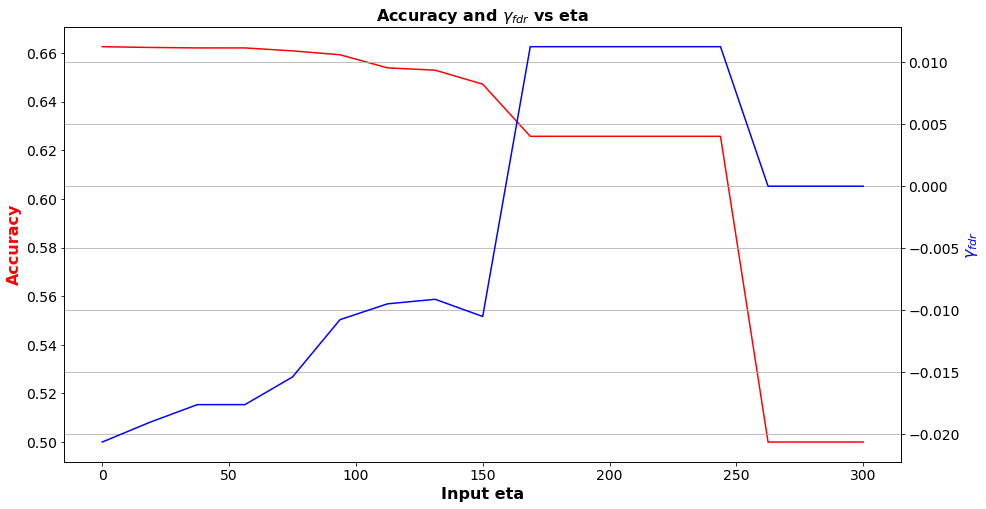

In [14]:
all_eta = np.linspace(0.0, 300, 17)

display(Markdown("### Plot of accuracy and output fairness vs input constraint (eta)"))

display(Markdown("#### Output fairness is represented by $\gamma_{fdr}$, which is the ratio of false discovery rate of different sensitive attribute values."))

fig, ax1 = plt.subplots(figsize=(15,8))
ax1.plot(all_eta, accuracies, color='r')
ax1.set_title('Accuracy and $\gamma_{fdr}$ vs eta', fontsize=16, fontweight='bold')
ax1.set_xlabel('Input eta', fontsize=16, fontweight='bold')
ax1.set_ylabel('Accuracy', color='r', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_eta,  statistical_rates, color='b')
ax2.set_ylabel('$\gamma_{fdr}$', color='b', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)